In [5]:
import re
def encode_label(label_list: list) -> (list, list):
    label_name = [[] for i in range(5)]

    label_encoded_list = []

    for label in label_list:
        if label is None:
            label_encoded_list.append(None)
            continue
        label_encoded = []

        for i in range(len(label) - 1):
            if not label[i] in label_name[i]:
                label_name[i].append(label[i])
                label_encoded.append(len(label_name[i]) - 1)
            else:
                label_encoded.append(label_name[i].index(label[i]))

        if label[4] is None:
            label_encoded.append([None])
        else:
            prop = []
            for ll in label[4]:
                if not ll in label_name[4]:
                    label_name[4].append(ll)
                    prop.append(len(label_name[4]) - 1)
                else:
                    prop.append(label_name[4].index(ll))
            label_encoded.append(prop)

        label_encoded_list.append(label_encoded)
    return label_name, label_encoded_list


def read_label(path: str) -> (list, list):
    label_list = []
    img_name = []
    with open(path, "r") as f:
        r = f.readline()
        while r:
            img_name.append(r[:5].strip())
            t = re.search('_missing descriptor', r)
            if t is not None:
                label_list.append(None)
                r = f.readline()
                continue
            else:
                label1 = []
                pattern = re.compile(r'\((.*?)\)')
                t = pattern.findall(r)
                for s in t[0:-1]:
                    c = s.split(" ")[-1].strip()
                    label1.append(c)

                pattern = re.compile(r'\'\((.*?)\)')
                t = pattern.findall(r)[0].strip()
                if not t == '':
                    prop = []
                    t = t.split(" ")
                    for i in t:
                        prop.append(i)
                    label1.append(prop)
                else:
                    label1.append(None)
            label_list.append(label1)
            r = f.readline()
    return label_list, img_name


def one_hot_prop(label_encoded_list: list, prop_num: int) -> list:
    label_list = []
    iii = 0
    for label in label_encoded_list:
        iii += 1
        if label is not None:
            prop_one_hot = [0 for i in range(prop_num)]
            prop = label.pop()
            for i in prop:
                if i is not None:
                    prop_one_hot[i] = 1
            label.append(prop_one_hot)
            label_list.append(label)
            if 1 in prop_one_hot:
                pass
        else:
            label_list.append(None)
    return label_list


def one_hot(index, num):
    label_one_hot = [0 for i in range(num)]
    label_one_hot[index] = 1
    return label_one_hot


def one_hot_label(label_list: list, label_name) -> list:
    label_one_hot = []
    for label in label_list:
        if label is not None:
            l = []
            for i in range(len(label_name) - 1):
                o = one_hot(label[i], len(label_name[i]))
                l += o
            l += label[-1]
        else:
            label_one_hot.append(None)
            continue
        label_one_hot.append(l)
    return label_one_hot


def label_pre_one_hot(path1, path2):
    label_list1, img_name1 = read_label(path1)
    # print(len(img_name1))
    label_list2, img_name2 = read_label(path2)
    # print(len(img_name2))
    label_list = label_list1 + label_list2

    male = 0
    total = 0

    # for label in label_list:
    #     if label is not None:
    #         total += 1
    #         if label[0] == 'male':
    #             male += 1
    # print(male, total)

    img_name = img_name1 + img_name2
    label_name, label_encoded_list = encode_label(label_list)
    prop_num = len(label_name[-1])
    label_list = one_hot_prop(label_encoded_list, prop_num)
    label_one_hot = one_hot_label(label_list, label_name)

    return label_one_hot, img_name, label_name


In [6]:
import raw_data_read_test as rd
import label_pre as lp
import cv2
from sklearn.neighbors import KNeighborsClassifier ###svm
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# 训练集
channels = 1  # 图像的通道数，灰度图为1
path_rawdata = r"./rawdata"
path_label1 = r"./faceDR"
path_label2 = r"./faceDS"
label_one_hot,img_name,label_list = label_pre_one_hot("./faceDR","./faceDS")
img_list = rd.read_rawdata(channels, path_rawdata, img_name)  # 图片矩阵

n = 0
for i in range(len(label_list)):
    num = i - n
    if label_list[num] is None:
        del label_list[num]
        del img_name[num]
        n = n + 1

array_of_img = []
for img in img_list:
    if img is not None:
        img = img / 255.0
        img = cv2.resize(img, (100, 100))
        array_of_img.append(img)
train_images = np.array(array_of_img)
array_of_img = []

array_of_labels = []
for label in label_one_hot:
    if label is not None:
        append_label = label[0]
        array_of_labels.append(int(append_label))
train_labels = np.array(array_of_labels)
array_of_labels = []

#h划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=3)
# 划分训练集的子训练集和子测试集
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

train_images = train_images.reshape(train_images.shape[0], -1)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 特征降维
pca = PCA(n_components=85)
newX = pca.fit_transform(X_train)
xx = pca.transform(X_test)

# # 定义模型
tree = tree.DecisionTreeClassifier(criterion="entropy",random_state=80,max_depth=15)  #决策树
tree.fit(newX, y_train)
knn = KNeighborsClassifier(n_neighbors=1)  # knn
knn.fit(newX, y_train)
svm = sklearn.svm.SVC()                    # svm
svm.fit(newX, y_train)

kfold = KFold(n_splits=10)

knn_scores = cross_val_score(knn, newX, y_train, cv=kfold)
print("knn Accuracy: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

svm_scores = cross_val_score(svm, newX, y_train, cv=kfold)
print("svm Accuracy: %0.2f (+/- %0.2f)" % (svm_scores.mean(), svm_scores.std() * 2))

tree_scores = cross_val_score(tree, newX, y_train, cv=kfold)
print("tree Accuracy: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))


cv_cross_knn = cross_validate(knn, newX, y_train, cv=kfold, scoring=('accuracy', 'f1'))
cv_cross_svm = cross_validate(svm, newX, y_train, cv=kfold, scoring=('accuracy', 'f1'))
cv_cross_tree = cross_validate(tree, newX, y_train, cv=kfold, scoring=('accuracy', 'f1'))

数据缺失： 1228
数据缺失： 1232
数据缺失： 1808
数据缺失： 4056
数据缺失： 4135
数据缺失： 4136
数据缺失： 5004
knn Accuracy: 0.86 (+/- 0.03)
svm Accuracy: 0.87 (+/- 0.03)
tree Accuracy: 0.77 (+/- 0.04)


In [5]:
print("knn测试结果：",cv_cross_knn)
print("svm测试结果：",cv_cross_svm)
print("tree测试结果：",cv_cross_tree)

knn测试结果： {'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00799966, 0.        , 0.        , 0.0019784 , 0.00200033]), 'score_time': array([0.03200722, 0.02400517, 0.02400613, 0.02400613, 0.02400851,
       0.02024627, 0.02400422, 0.02400589, 0.02478981, 0.01910782]), 'test_accuracy': array([0.84061697, 0.84575835, 0.87660668, 0.85861183, 0.86375321,
       0.84061697, 0.83547558, 0.86375321, 0.87371134, 0.88402062]), 'test_f1': array([0.84263959, 0.83050847, 0.86363636, 0.85564304, 0.84813754,
       0.83060109, 0.83505155, 0.87104623, 0.86501377, 0.87804878])}
svm测试结果： {'fit_time': array([0.56181669, 0.56016493, 0.52829623, 0.55326152, 0.56014276,
       0.51585865, 0.48056054, 0.56933522, 0.62361956, 0.6716702 ]), 'score_time': array([0.12002707, 0.12002468, 0.1191113 , 0.11202669, 0.12002611,
       0.09438872, 0.11599088, 0.12734604, 0.14401007, 0.12578988]), 'test_accuracy': array([0.8688946 , 0.85604113, 0.88174807, 0.86118252, 0.86632391,


In [7]:
kfold = KFold(n_splits=10)
knn_scores = cross_val_score(knn, newX, y_train, cv=kfold)
cv_cross_knn = cross_validate(knn, newX, y_train, cv=kfold, scoring=('accuracy', 'f1'))
print("knn Accuracy: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))
print("knn测试结果：",cv_cross_knn)

knn Accuracy: 0.86 (+/- 0.03)
knn测试结果： {'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.00800252,
       0.00300145, 0.00798631, 0.        , 0.00448799, 0.00200033]), 'score_time': array([0.02398276, 0.02400446, 0.02376008, 0.01789713, 0.02142787,
       0.01596212, 0.02271223, 0.02400517, 0.02334976, 0.01433063]), 'test_accuracy': array([0.84318766, 0.84575835, 0.87660668, 0.86375321, 0.86632391,
       0.84061697, 0.83804627, 0.8688946 , 0.86340206, 0.88402062]), 'test_f1': array([0.84556962, 0.83050847, 0.86363636, 0.86089239, 0.85057471,
       0.83060109, 0.83804627, 0.87651332, 0.85399449, 0.87804878])}


In [9]:
kfold = KFold(n_splits=10)
tree_scores = cross_val_score(tree, newX, y_train, cv=kfold)
print("tree Accuracy: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
cv_cross_tree = cross_validate(tree, newX, y_train, cv=kfold, scoring=('accuracy', 'f1'))
print("tree测试结果：",cv_cross_tree)

tree Accuracy: 0.77 (+/- 0.05)
tree测试结果： {'fit_time': array([0.39481425, 0.33608437, 0.33552694, 0.34408474, 0.33532453,
       0.39209723, 0.33167601, 0.39412856, 0.41187096, 0.40735888]), 'score_time': array([0.        , 0.00800157, 0.        , 0.        , 0.        ,
       0.008003  , 0.        , 0.        , 0.        , 0.00887632]), 'test_accuracy': array([0.73007712, 0.79691517, 0.79434447, 0.78920308, 0.76349614,
       0.75321337, 0.75578406, 0.7840617 , 0.75257732, 0.80670103]), 'test_f1': array([0.72727273, 0.78474114, 0.77272727, 0.79292929, 0.74585635,
       0.73913043, 0.75324675, 0.79710145, 0.72571429, 0.79892761])}


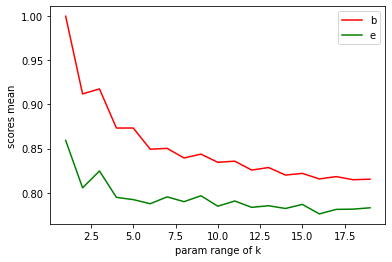

In [30]:
from matplotlib import pyplot as plt
from sklearn.model_selection import validation_curve

param_name = 'n_neighbors'
param_range = range(1, 20)

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), newX, y_train, cv=kfold,
    param_name=param_name, param_range=param_range,
    scoring='accuracy')
#训练集和测试集得分
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range,train_scores_mean, color='red', label='train')
plt.plot(param_range, test_scores_mean, color='green', label='test')
plt.legend('best')
plt.xlabel('param range of k')
plt.ylabel('scores mean')
plt.show()

In [59]:
#创建决策树,用网格搜索和交叉验证找最优参数并拟合数据
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
def fit_model_k_fold(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    k_fold = KFold(n_splits=10)
    
    #  Create a decision tree clf object
#     clf = DecisionTreeClassifier(random_state=80,criterion = 'entropy')
    clf = DecisionTreeClassifier(random_state=80)
    
    params = {'max_depth':range(1,21),'criterion':np.array(['entropy'])}
#     params = {'max_depth':range(1,21)}
    # Transform 'accuracy_score' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(accuracy_score)

    # Create the grid search object
    grid = GridSearchCV(clf, param_grid=params,scoring=scoring_fnc,cv=k_fold)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [60]:
clf = fit_model_k_fold(newX, y_train)

In [61]:
print ("k_fold Parameter 'max_depth' is {} for the optimal model.".format(clf.get_params()['max_depth']))
print ("k_fold Parameter 'criterion' is {} for the optimal model.".format(clf.get_params()['criterion']))

k_fold Parameter 'max_depth' is 15 for the optimal model.
k_fold Parameter 'criterion' is entropy for the optimal model.


In [62]:
score = clf.score(xx,y_test)
print('最优参数的决策树训练准确率：',score*100,'%')

最优参数的决策树训练准确率： 81.06995884773663 %


In [ ]:
#SVM调参
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import make_scorer

k_fold = KFold(n_splits=10)
#params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1, 10, 100,1000]}]

params = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scoring_fnc = make_scorer(accuracy_score)
grid = GridSearchCV(svm, param_grid=params,scoring=scoring_fnc,cv=k_fold)
grid = grid.fit(newX, y_train)


In [11]:
clf = grid.best_estimator_
print ("k_fold Parameter 'gamma' is {} for the optimal model.".format(clf.get_params()['gamma']))
print ("k_fold Parameter 'kernel' is {} for the optimal model.".format(clf.get_params()['kernel']))
print ("k_fold Parameter 'C' is {} for the optimal model.".format(clf.get_params()['C']))

k_fold Parameter 'gamma' is 0.001 for the optimal model.
k_fold Parameter 'kernel' is rbf for the optimal model.
k_fold Parameter 'C' is 1000 for the optimal model.


In [12]:
score = grid.score(xx,y_test)
print('最优参数的svm向量机训练准确率：',score*100,'%')

最优参数的svm向量机训练准确率： 91.1522633744856 %


In [13]:
svm = sklearn.svm.SVC(gamma = 1e-3,kernel = 'rbf',C= 1000)
kfold = KFold(n_splits=10)
svm_scores = cross_val_score(svm, newX, y_train, cv=kfold)
print("svm Accuracy: %0.2f (+/- %0.2f)" % (svm_scores.mean(), svm_scores.std() * 2))
cv_cross_svm = cross_validate(svm, newX, y_train, cv=kfold, scoring=('accuracy', 'f1'))
print("svm测试结果：",cv_cross_svm)

svm Accuracy: 0.89 (+/- 0.03)
svm测试结果： {'fit_time': array([1.60518718, 1.46585608, 1.52617598, 1.2834897 , 1.44313622,
       1.3936727 , 1.21206641, 1.5039115 , 1.5171628 , 1.45525241]), 'score_time': array([0.05903101, 0.06401324, 0.05573511, 0.05925059, 0.05600286,
       0.06525517, 0.05711007, 0.06400847, 0.05558181, 0.06608105]), 'test_accuracy': array([0.88431877, 0.90488432, 0.88431877, 0.87403599, 0.87917738,
       0.88688946, 0.86375321, 0.88174807, 0.90721649, 0.90721649]), 'test_f1': array([0.88549618, 0.89693593, 0.87252125, 0.87272727, 0.86685552,
       0.88172043, 0.86375321, 0.88834951, 0.9       , 0.90425532])}
